## Statistiques sur les tailles des molécules et suppression des données marginales

Nous avons remarqué lors de la création des jeux de données qu'il existe des molécules vides dans les données, et nous nous doutons que la représentation des molécules de différentes tailles n'est pas uniforme et que le jeu de données contient moins d'exemples de molécules de grande taille.

Dans l'idée de travailler sur un jeu plus propre (contenant moins de données aberrantes) et de travailler sur des molécules plus petites afin de gagner de la mémoire et du temps d'exécution, nous allons créer un nouveau jeu de données contenant les molécules de tailles supérieures ou égales à 2, et inférieures à un certain seuil que nous allons déterminer en analysant la distribution des tailles de molécules dans le jeu.

La taille maximale des molécules que nous retenons est 60. En effet, aucune taille n'est représentée plus de 162 fois au dela de ce seuil, alors que la taille la plus représentée (30) est présente plus de 200000 fois.



#### Recherche de la molécule de plus grande taille

In [1]:
import h5py
import numpy as np

riken_data = h5py.File("../data/riken_v2.h5")

anums = np.array(riken_data["anums"])

max_len = 0

for anums_mol in anums:
    
    if len(anums_mol) > max_len:
        max_len = len(anums_mol)

print("La taille de la molécule de plus grande taille est : "+str(max_len))


/home/etudiant/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


KeyboardInterrupt: 

##### Sortie 

La taille de la molécule de plus grande taille est : 137


#### Distribution des tailles

In [2]:
import h5py
import numpy as np

riken_data = h5py.File("../data/riken_v2.h5")

anums = np.array(riken_data["anums"])

np_tailles = np.zeros(shape=(150,))

for anums_mol in anums:
    
    taille = len(anums_mol)
    np_tailles[taille] += 1
    
    


#### Représentation graphique des tailles

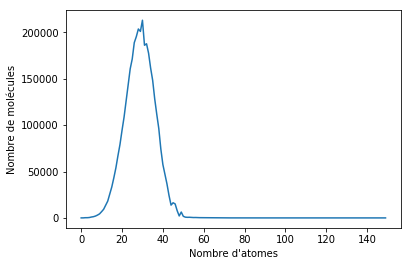

In [3]:
%matplotlib inline  
import matplotlib.pyplot as plt


plt.plot(np_tailles)
plt.ylabel("Nombre de molécules")
plt.xlabel("Nombre d'atomes")
plt.savefig("../figures/8.0_distribution_molécules.png")
plt.show()

#### Tableau des tailles

In [55]:
import pandas as pd

df = pd.DataFrame(np_tailles)

def print_full(x):
    """ Permet d'afficher le tableau entier, solution prise sur 
    https://stackoverflow.com/questions/19124601/is-there-a-way-to-pretty-print-the-entire-pandas-series-dataframe"""
    
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(df)


            0
0        26.0
1        37.0
2       231.0
3       242.0
4       426.0
5       947.0
6      1317.0
7      1997.0
8      3055.0
9      4363.0
10     6743.0
11     9310.0
12    13581.0
13    18102.0
14    25974.0
15    33444.0
16    43319.0
17    53984.0
18    67005.0
19    79186.0
20    94375.0
21   108665.0
22   126069.0
23   143721.0
24   160675.0
25   171388.0
26   188952.0
27   195435.0
28   203662.0
29   201038.0
30   213096.0
31   186110.0
32   187751.0
33   177544.0
34   161574.0
35   148329.0
36   128365.0
37   111839.0
38    96358.0
39    74291.0
40    57552.0
41    47343.0
42    36655.0
43    24208.0
44    13807.0
45    16335.0
46    15086.0
47     7778.0
48     2134.0
49     6320.0
50     1754.0
51      819.0
52      645.0
53      695.0
54      555.0
55      407.0
56      443.0
57      338.0
58      280.0
59      256.0
60      213.0
61      162.0
62      140.0
63      127.0
64      103.0
65       65.0
66       78.0
67       44.0
68       47.0
69       39.0
70    

In [56]:
print(int(np.sum(np_tailles[2:61])))
print(np_tailles[2:61])

3676086
[2.31000e+02 2.42000e+02 4.26000e+02 9.47000e+02 1.31700e+03 1.99700e+03
 3.05500e+03 4.36300e+03 6.74300e+03 9.31000e+03 1.35810e+04 1.81020e+04
 2.59740e+04 3.34440e+04 4.33190e+04 5.39840e+04 6.70050e+04 7.91860e+04
 9.43750e+04 1.08665e+05 1.26069e+05 1.43721e+05 1.60675e+05 1.71388e+05
 1.88952e+05 1.95435e+05 2.03662e+05 2.01038e+05 2.13096e+05 1.86110e+05
 1.87751e+05 1.77544e+05 1.61574e+05 1.48329e+05 1.28365e+05 1.11839e+05
 9.63580e+04 7.42910e+04 5.75520e+04 4.73430e+04 3.66550e+04 2.42080e+04
 1.38070e+04 1.63350e+04 1.50860e+04 7.77800e+03 2.13400e+03 6.32000e+03
 1.75400e+03 8.19000e+02 6.45000e+02 6.95000e+02 5.55000e+02 4.07000e+02
 4.43000e+02 3.38000e+02 2.80000e+02 2.56000e+02 2.13000e+02]


##### Suppression des données marginales

On va ici chercher à réduire le jeu de données aux molécules ayant les tailles les plus représentées, et les tailles les plus utiles pour l'apprentissage des modèles. En effet, les molécules de tailles 0 ou 1 n'ont pas d'intérêt pour nous, et les molécules de tailles trop importantes (supérieure à 60) sont peu représentées et ne constituent donc pas suffisamment d'exemples pour entraîner un RN efficace pour ces tailles.

In [63]:
import h5py
import time
import numpy as np

def creation_jeu_reduit(original_dataset_location, reduced_dataset_location):
    
    start_time = time.time()    

    
    # On créé les jeux de données
    riken_original = h5py.File(original_dataset_location, 'r')
    riken_reduced = h5py.File(reduced_dataset_location, 'w')

    # On calcule le nombre d'exemples à garder du jeu initial
    taille_reduced = int(np.sum(np_tailles[2:61]))
    print("taille prévue : "+str(taille_reduced))

    try:
        # On créé les nouveaux datasets
        varlen_floatarray = h5py.special_dtype(vlen=np.dtype("float32"))
        
        pubchem_id = riken_reduced.create_dataset("pubchem_id", shape=(taille_reduced,), dtype=np.int32,
                                                  compression='gzip', chunks=True)

        anums = riken_reduced.create_dataset("anums", shape=(taille_reduced,), dtype=varlen_floatarray,
                                            compression='gzip', chunks=True)

        amasses = riken_reduced.create_dataset("amasses", shape=(taille_reduced,), dtype=varlen_floatarray,
                                            compression='gzip', chunks=True)

        riken_coords = riken_reduced.create_dataset("riken_coords", shape=(taille_reduced,), 
                                                    dtype=varlen_floatarray, compression='gzip', chunks=True)

        
        # On créé les nouveaux datasets en itérant sur les datasets existants
        original_size = len(riken_original["pubchem_id"])
        
        # Index du premier élément du batch courant (non défini pour le moment)
        curr_batch_idx = None
        taille_batch_max = 100000
        
        selected_mol = 0
        
        for original_idx in range(original_size):
            
            if original_idx%taille_batch_max == 0:
                print("Traitement molécule "+str(original_idx)+" ("+str(time.time() - start_time)+"s)")
                
                original_batch_idx = 0
                
                # On écrit sur le disque les infos du batch précédent s'il existe un batch précédent
                if curr_batch_idx is not None :
                    curr_batch_actual_size = len(arr_pubchem_ids)
                    pubchem_id[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_pubchem_ids
                    anums[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_anums
                    amasses[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_amasses
                    riken_coords[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_riken_coords
                    
                # On met à jour la première molécule du batch courant
                if curr_batch_idx is None :
                    curr_batch_idx = 0
                    curr_absolute_idx = 0
                else:
                    curr_batch_idx += curr_batch_actual_size
                    curr_absolute_idx += taille_batch_courant

                # On calcule la taille du nouveau batch
                taille_batch_courant = min(taille_batch_max, original_size - original_idx)
                
                # On charge les données en mémoire
                original_pubchem_ids = np.array(riken_original["pubchem_id"][curr_absolute_idx:curr_absolute_idx+taille_batch_courant])
                original_anums = np.array(riken_original["anums"][curr_absolute_idx:curr_absolute_idx+taille_batch_courant])
                original_masses = np.array(riken_original["amasses"][curr_absolute_idx:curr_absolute_idx+taille_batch_courant])
                original_coords = np.array(riken_original["riken_coords"][curr_absolute_idx:curr_absolute_idx+taille_batch_courant])
            
                # On créé les tableaux
                arr_pubchem_ids = []
                arr_anums = []
                arr_amasses = []
                arr_riken_coords = []
            
            # On ne traite que les molécules de taille acceptable
            curr_len = len(original_anums[original_batch_idx])
            if curr_len >= 2 and curr_len <=60:
                
                selected_mol += 1
                
                # On enregistre les informations de la molécule
                arr_pubchem_ids.append(original_pubchem_ids[original_batch_idx])
                arr_anums.append(original_anums[original_batch_idx])
                arr_amasses.append(original_masses[original_batch_idx])
                arr_riken_coords.append(original_coords[original_batch_idx])
                
            original_batch_idx += 1
                                
        # On écrit le dernier batch sur le disque
        curr_batch_actual_size = len(arr_pubchem_ids)
        pubchem_id[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_pubchem_ids
        anums[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_anums
        amasses[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_amasses
        riken_coords[curr_batch_idx:curr_batch_idx+curr_batch_actual_size] = arr_riken_coords

        riken_reduced.flush()
        
        print(str(selected_mol)+" molécules sélectionnées")
        print("--- %s seconds ---" % (time.time() - start_time))


    finally:
        riken_original.close()
        riken_reduced.close()


In [64]:
print("Création jeu réduit")
creation_jeu_reduit("../data/riken_v2.h5", "../data/riken_v2_reduced.h5")
#creation_jeu_reduit("../data/minimal_set_riken_v2.h5", "../data/minimal_set_reduced.h5")

Création jeu réduit
taille prévue : 3676086
Traitement molécule 0 (0.12321138381958008s)
Traitement molécule 100000 (1.060945987701416s)
Traitement molécule 200000 (3.403879165649414s)
Traitement molécule 300000 (5.7834227085113525s)
Traitement molécule 400000 (8.160250902175903s)
Traitement molécule 500000 (11.156449556350708s)
Traitement molécule 600000 (13.727065086364746s)
Traitement molécule 700000 (16.108662366867065s)
Traitement molécule 800000 (18.436722993850708s)
Traitement molécule 900000 (20.891268968582153s)
Traitement molécule 1000000 (24.197532176971436s)
Traitement molécule 1100000 (27.209837198257446s)
Traitement molécule 1200000 (29.866445064544678s)
Traitement molécule 1300000 (32.36279225349426s)
Traitement molécule 1400000 (34.75176239013672s)
Traitement molécule 1500000 (37.60341787338257s)
Traitement molécule 1600000 (40.222100257873535s)
Traitement molécule 1700000 (42.69221019744873s)
Traitement molécule 1800000 (44.98573851585388s)
Traitement molécule 1900000 

#### Représentation graphique du nouveau jeu de données

In [3]:
%matplotlib inline  
import h5py
import numpy as np

riken_data = h5py.File("../data/riken_v2_reduced.h5")

anums = riken_data["anums"]

np_tailles = np.zeros(shape=(150,))

for anums_mol in anums:
    
    taille = len(anums_mol)
    np_tailles[taille] += 1



/home/etudiant/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


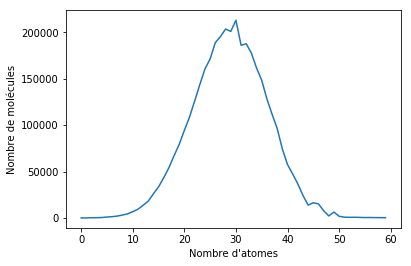

In [4]:
import matplotlib.pyplot as plt
plt.plot(np_tailles[:60])
plt.ylabel("Nombre de molécules")
plt.xlabel("Nombre d'atomes")
plt.savefig("../figures/8.0_distribution_molécules_post_réduction.png")
plt.show()

#### Tableau des tailles des nouvelles données

In [5]:
import pandas as pd

df = pd.DataFrame(np_tailles)

def print_full(x):
    """ Permet d'afficher le tableau entier, solution prise sur 
    https://stackoverflow.com/questions/19124601/is-there-a-way-to-pretty-print-the-entire-pandas-series-dataframe"""
    
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(df)


            0
0         0.0
1         0.0
2       231.0
3       242.0
4       426.0
5       947.0
6      1317.0
7      1997.0
8      3055.0
9      4363.0
10     6743.0
11     9310.0
12    13581.0
13    18102.0
14    25974.0
15    33444.0
16    43319.0
17    53984.0
18    67005.0
19    79186.0
20    94375.0
21   108665.0
22   126069.0
23   143721.0
24   160675.0
25   171388.0
26   188952.0
27   195435.0
28   203662.0
29   201038.0
30   213096.0
31   186110.0
32   187751.0
33   177544.0
34   161574.0
35   148329.0
36   128365.0
37   111839.0
38    96358.0
39    74291.0
40    57552.0
41    47343.0
42    36655.0
43    24208.0
44    13807.0
45    16335.0
46    15086.0
47     7778.0
48     2134.0
49     6320.0
50     1754.0
51      819.0
52      645.0
53      695.0
54      555.0
55      407.0
56      443.0
57      338.0
58      280.0
59      256.0
60      213.0
61        0.0
62        0.0
63        0.0
64        0.0
65        0.0
66        0.0
67        0.0
68        0.0
69        0.0
70    